<a href="https://colab.research.google.com/github/siminsharif/st/blob/main/SpecialTopic_HM02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset

# Load the 'yelp_review_full' dataset (using the 'train' split for sampling)
dataset = load_dataset('yelp_review_full', split='train')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
# 2. Convert to pandas DataFrame
import pandas as pd

yelp_df = pd.DataFrame(dataset[:])  # Use dataset[:] to get all rows as a list of dicts


In [3]:
# 3. Sample 50,000 random entries
sample_size = 50000
# Ensure sample_size does not exceed the total number of rows in yelp_df
actual_sample_size = min(sample_size, len(yelp_df))

yelp_df_sampled = yelp_df.sample(n=actual_sample_size, random_state=42)

In [4]:
# 4. Display the first few rows and shape of the sampled DataFrame
print(f"Sampled DataFrame shape: {yelp_df_sampled.shape}")
print("First 5 rows of the sampled Yelp dataset:")
print(yelp_df_sampled.head())

Sampled DataFrame shape: (50000, 2)
First 5 rows of the sampled Yelp dataset:
        label                                               text
177288      0  First of all i'm not a big fan of buffet, i tr...
238756      1  Thanks Yelp. I was looking for the words to de...
604225      2  Service was so-so. They were receiving a deliv...
2838        2  Stamoolis Brothers is one of the Strip Distric...
586957      0  I want to give a 2 stars because the service s...


تولید داده‌های نمونه و آموزش مدل

In [5]:
# Make sure 'label' column exists
print(yelp_df_sampled.columns)


Index(['label', 'text'], dtype='object')


In [6]:
# Create sentiment labels: 3, 4, 5 stars → positive, 1, 2 stars → negative
yelp_df_sampled['sentiment'] = yelp_df_sampled['label'].apply(
    lambda x: 'positive' if x >= 2 else 'negative'
)

# Verify
print(yelp_df_sampled[['label', 'sentiment']].head())


        label sentiment
177288      0  negative
238756      1  negative
604225      2  positive
2838        2  positive
586957      0  negative


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Split data into features and labels
X = yelp_df_sampled['text']       # review text
y = yelp_df_sampled['sentiment']  # positive / negative labels

# 2. Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Train a simple Logistic Regression classifier
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# 5. Evaluate the model
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8583

Classification Report:

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      4003
    positive       0.87      0.90      0.88      5997

    accuracy                           0.86     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000



 ارزیابی مدل با معیارهای مختلف

Accuracy: 0.8583
Precision (positive class): 0.8696
Recall (positive class): 0.8984
F1-score (positive class): 0.8838

Classification Report:

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      4003
    positive       0.87      0.90      0.88      5997

    accuracy                           0.86     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000



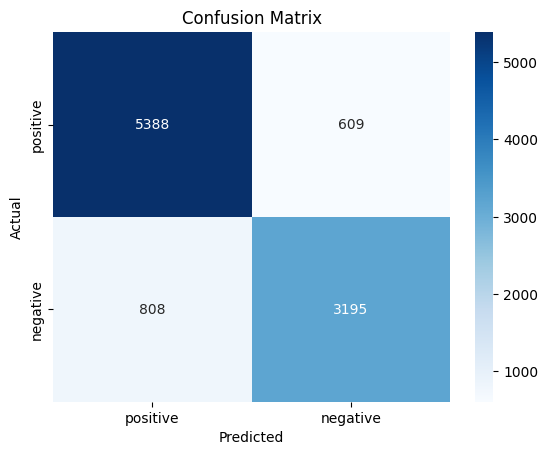

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_tfidf)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision, Recall, F1-Score (per class and average)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

print(f"Precision (positive class): {precision:.4f}")
print(f"Recall (positive class): {recall:.4f}")
print(f"F1-score (positive class): {f1:.4f}")

# 3. Classification report for all classes
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive','negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


منحنی ROC

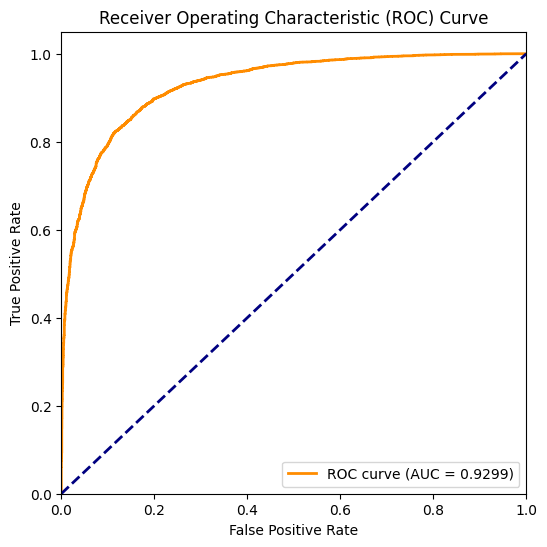

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # probability for 'positive'

# 2. Encode labels as binary (needed for ROC)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()  # 1 for positive, 0 for negative

# 3. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

# 4. Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


تست مدل با نمونه‌های جدید

In [10]:
# Example new reviews
new_reviews = [
    "I absolutely loved this place! The food was amazing and the service was great.",
    "The experience was terrible. The food was cold and the staff was rude.",
    "It was okay, not too bad but nothing special either."
]

# 1. Convert new reviews to TF-IDF features using the trained vectorizer
new_reviews_tfidf = vectorizer.transform(new_reviews)

# 2. Predict sentiment using the trained model
predictions = model.predict(new_reviews_tfidf)

# 3. Predict probabilities (optional, for confidence)
probabilities = model.predict_proba(new_reviews_tfidf)

# 4. Display results
for review, pred, prob in zip(new_reviews, predictions, probabilities):
    print(f"Review: {review}")
    print(f"Predicted sentiment: {pred} (Confidence: {max(prob):.2f})\n")


Review: I absolutely loved this place! The food was amazing and the service was great.
Predicted sentiment: positive (Confidence: 1.00)

Review: The experience was terrible. The food was cold and the staff was rude.
Predicted sentiment: negative (Confidence: 1.00)

Review: It was okay, not too bad but nothing special either.
Predicted sentiment: negative (Confidence: 0.74)



تفسیر معیارهای ارزیابی

/tmp/ipython-input-1063075402.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_r')


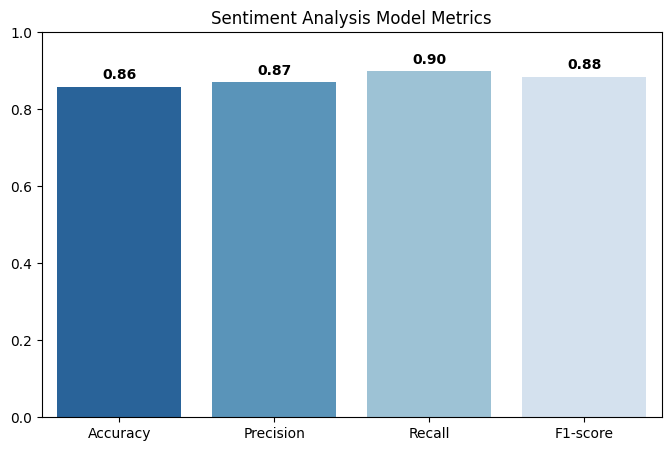

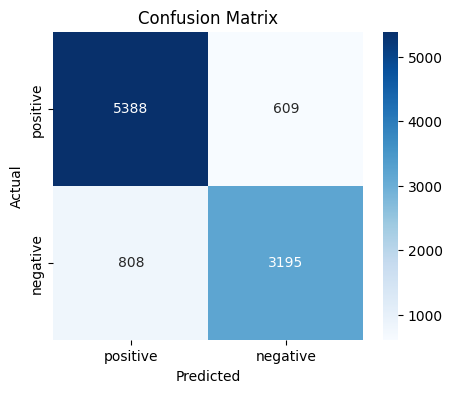

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_tfidf)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

# Create a bar chart for metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_r')
plt.ylim(0, 1)
plt.title('Sentiment Analysis Model Metrics')
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive','negative'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Plot classes distribution on all parts of dataset

In [12]:
# Train set DataFrame
train_df = pd.DataFrame({
    'text': X_train.values,
    'sentiment': y_train.values
})

# Test set DataFrame
test_df = pd.DataFrame({
    'text': X_test.values,
    'sentiment': y_test.values
})


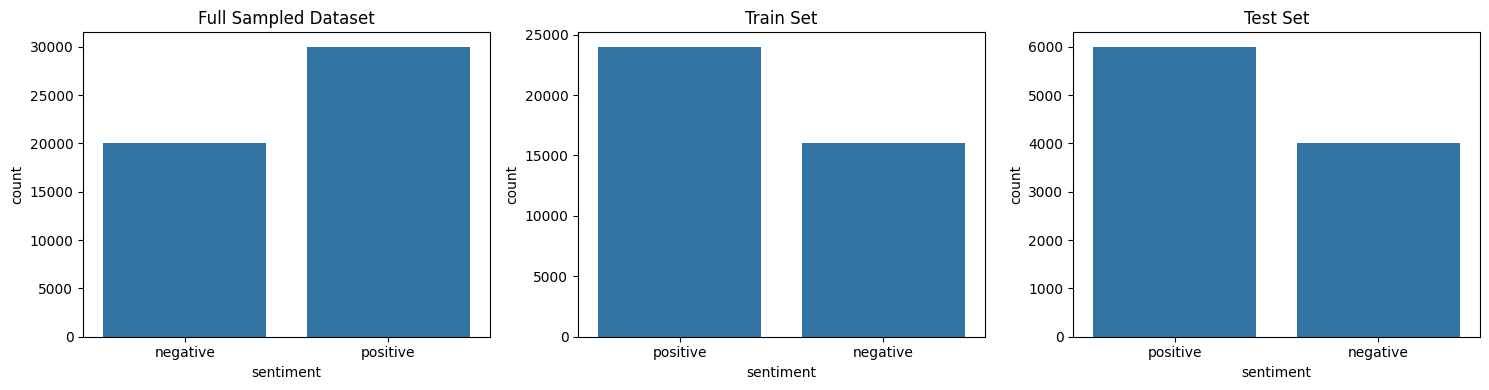

In [13]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.countplot(x='sentiment', data=yelp_df_sampled)
plt.title('Full Sampled Dataset')

plt.subplot(1,3,2)
sns.countplot(x='sentiment', data=train_df)
plt.title('Train Set')

plt.subplot(1,3,3)
sns.countplot(x='sentiment', data=test_df)
plt.title('Test Set')

plt.tight_layout()
plt.show()


For each class of the dataset plot word cloud

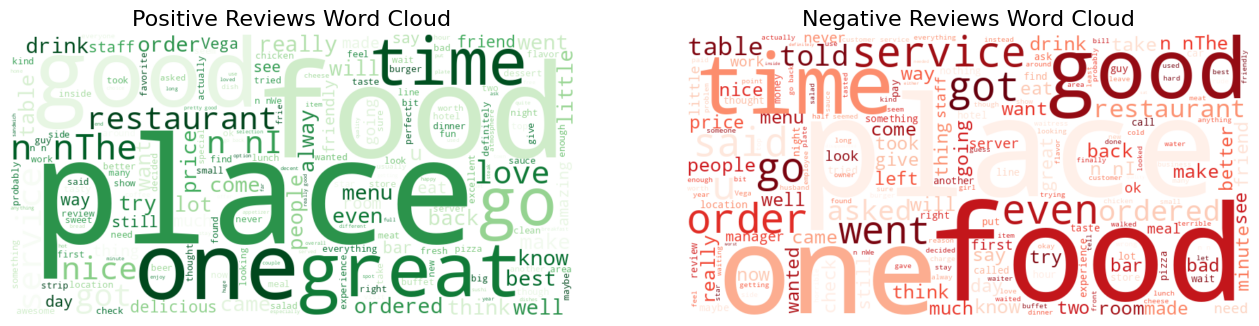

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text for each sentiment class
positive_text = " ".join(yelp_df_sampled[yelp_df_sampled['sentiment'] == 'positive']['text'].astype(str))
negative_text = " ".join(yelp_df_sampled[yelp_df_sampled['sentiment'] == 'negative']['text'].astype(str))

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=16)

plt.show()


ترسیم ابر کلمات با حذف کلمات پر تکرار به عنوان پیش پردازش داده ها

Class negative: 100 frequent words extracted
Class positive: 100 frequent words extracted

Number of words common across all classes: 84


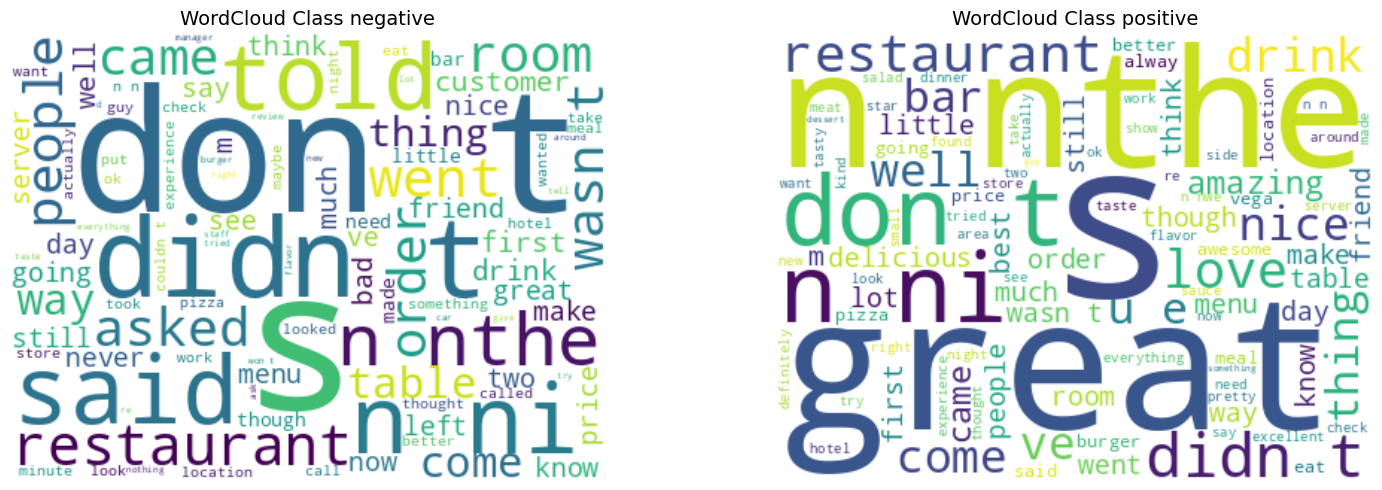


Top words per class after removing common words:

Class negative: [('i', 93822), ('n', 31866), ('t', 25920), ('s', 16214), ('she', 9320), ('he', 8830), ('them', 6612), ('don', 6197), ('after', 6092), ('didn', 5836)]

Class positive: [('i', 105143), ('n', 46340), ('s', 25829), ('t', 24504), ('great', 14693), ('also', 7410), ('nice', 7193), ('nthe', 7174), ('ni', 6880), ('ve', 6865)]


In [15]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import os

# -----------------------------
# Parameters
# -----------------------------
persian_font = None  # Example: "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
TOP_K = 100  # Number of frequent words per class to consider as stopwords
TOP_N_WORDS = 10  # Number of top words to display per class

# -----------------------------
# Function: preprocess text
# -----------------------------
def preprocess_text(text, stop_words=set()):
    """
    Preprocess text by:
    - Lowercasing
    - Removing non-alphabetic characters
    - Removing stopwords
    """
    text = re.sub(r'[^آ-یA-Za-z\s]', ' ', text)  # Keep letters only
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# -----------------------------
# Step 1: Identify common words across classes
# -----------------------------
def get_common_words(df, text_col='text', label_col='sentiment', top_k=TOP_K):
    classes = df[label_col].unique()
    class_word_counts = {}

    for class_label in classes:
        class_texts = ' '.join(df[df[label_col] == class_label][text_col].astype(str))
        words = class_texts.split()
        word_counts = Counter(words)
        top_words = set([word for word, _ in word_counts.most_common(top_k)])
        class_word_counts[class_label] = top_words
        print(f"Class {class_label}: {len(top_words)} frequent words extracted")

    # Common words across all classes
    common_words = set.intersection(*class_word_counts.values())
    print(f"\nNumber of words common across all classes: {len(common_words)}")
    return common_words, classes

# -----------------------------
# Step 2: Generate WordClouds per class
# -----------------------------
def plot_wordclouds(df, text_col='text', label_col='sentiment', common_words=set(), classes=None, persian_font=None):
    if classes is None:
        classes = df[label_col].unique()

    fig, axes = plt.subplots(1, len(classes), figsize=(16, 5))

    for i, class_label in enumerate(classes):
        class_texts = ' '.join(df[df[label_col] == class_label][text_col].astype(str))
        processed_text = preprocess_text(class_texts, stop_words=common_words)

        try:
            if persian_font and os.path.exists(persian_font):
                wc = WordCloud(
                    font_path=persian_font,
                    background_color='white',
                    width=400,
                    height=300,
                    max_words=100
                ).generate(processed_text)
            else:
                wc = WordCloud(
                    background_color='white',
                    width=400,
                    height=300,
                    max_words=100
                ).generate(processed_text)
        except Exception as e:
            print(f"Error generating WordCloud for class {class_label}: {e}")
            continue

        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'WordCloud Class {class_label}', fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Step 3: Show top frequent words after stopword removal
# -----------------------------
def show_top_words(df, text_col='text', label_col='sentiment', common_words=set(), top_n=TOP_N_WORDS):
    classes = df[label_col].unique()
    print("\nTop words per class after removing common words:")
    for class_label in classes:
        class_texts = ' '.join(df[df[label_col] == class_label][text_col].astype(str))
        processed_text = preprocess_text(class_texts, stop_words=common_words)
        words = processed_text.split()
        top_words = Counter(words).most_common(top_n)
        print(f"\nClass {class_label}: {top_words}")

# -----------------------------
# Example usage with yelp_df_sampled
# -----------------------------
# Step 1: Compute common words
common_words, classes = get_common_words(yelp_df_sampled, text_col='text', label_col='sentiment', top_k=TOP_K)

# Step 2: Generate WordClouds
plot_wordclouds(yelp_df_sampled, text_col='text', label_col='sentiment', common_words=common_words, classes=classes, persian_font=persian_font)

# Step 3: Show top frequent words after stopword removal
show_top_words(yelp_df_sampled, text_col='text', label_col='sentiment', common_words=common_words, top_n=TOP_N_WORDS)
